# Restaurant Visitor Forecasting

## Table of Contents
[Overvew](#Overview)   
[Merge tables](#Merge_tables)   
[결측치 처리](#결측치_처리)   
[데이터 전처리](#데이터_전처리)   
[모델 설계](#모델_설계)   
[References](#References)

## Overview
이 대회에서는 예약 및 방문 데이터를 사용하여 **미래 날짜의 레스토랑 총 방문자 수를 예측**해야 합니다.

평가에는 **RMSLE**를 사용합니다
\\[ \sqrt{ \frac{1}{n} \sum_{i=1}^{n}{ (\log( p_i + 1) - \log(a_i + 1))^2} }\\]

\\(n\\) is 관측된 총 숫자   
\\(p_i\\) is 예상한 방문자 수   
\\(a_i\\) is 실제 방문자 수   
\\(\log𝑥\\) is \\(x\\)의 자연로그


**제공되는 데이터는 다음과 같습니다.**
* Hot Pepper Gourmet (hpg): 사용자들이 레스토랑을 검색하고 온라인 예약할 수 있는 서비스
* AirREGI / Restaurant Board (air): 매장에서 사용하는 예약관리시스템 (POS)
* 훈련 데이터는 2016년~2017년 4월까지, 테스트 데이터는 2017년 4월과 5월 마지막주까지 제공됩니다
* 테스트 데이터에는 골든위크 기간이 포함되어있습니다.
* 테스트 데이터 세트에는 레스토랑이 문을 닫고 방문자가 없는 날이 있었습니다. 스코어링 시 무시됩니다. 훈련 세트는 레스토랑이 문을 닫는 날을 생략합니다.

**air_visit_data.csv**: air 레스토랑의 과거 방문 데이터입니다. 이것은 본질적으로 주요 훈련 데이터 세트입니다.  
**air_reserve.csv** / **hpg_reserve.csv**: air / hpg 시스템을 통한 예약.  
**air_store_info.csv** / **hpg_store_info.csv**: 장르 및 위치를 포함한 air / hpg 레스토랑에 대한 세부 정보입니다.  
**store_id_relation.csv**: air와 hpg id를 연결합니다.
**date_info.csv**: 기본적으로 일본 공휴일에 플래그를 지정합니다.  
**sample_submission.csv**: 테스트 세트 역할을 합니다. id는 air id와 방문 날짜를 결합하여 구성됩니다.

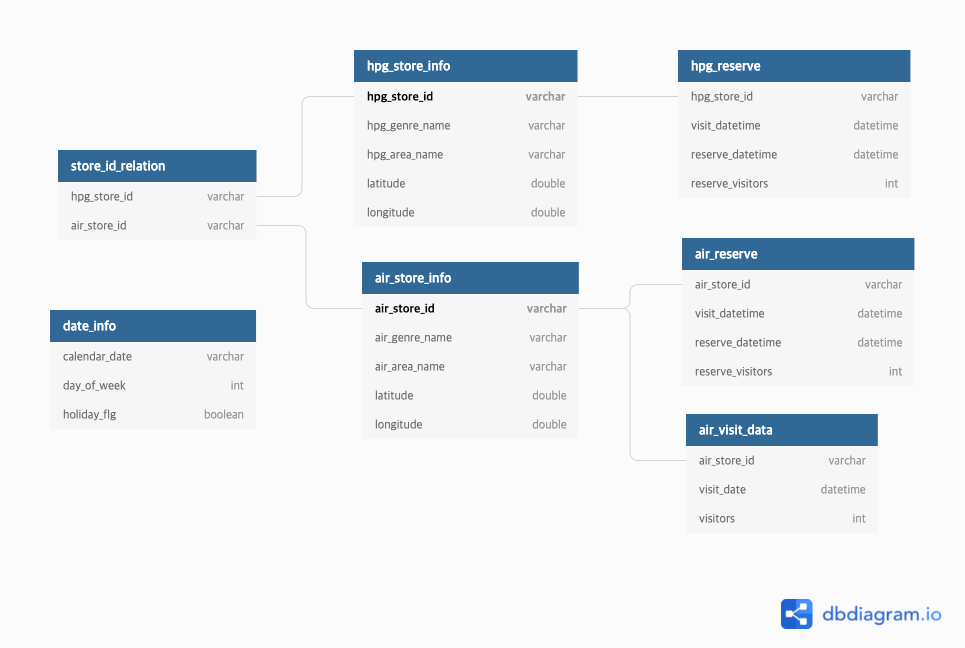

In [ ]:
# import libraries
import time
import calendar
import numpy as np
import pandas as pd
from dateutil.parser import parse
from datetime import date, timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

import os

%matplotlib inline

# config
DATA_DIR = '../input/recruit-restaurant-visitor-forecasting'

# define utility funtions
def rmsle(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

calendar.setfirstweekday(6)
def get_week_of_month(date_str):
    year = int(date_str[:4])
    month = int(date_str[5:7])
    day = int(date_str[8:10])
    x = np.array(calendar.monthcalendar(year, month))
    week_of_month = np.where(x==day)[0][0] + 1
    return(week_of_month)

def save_submission(model, train, y, test, model_name):
    model.fit(train, y)
    pred = model.predict(test)
    pred = np.expm1(pred)
    
    data_dir = DATA_DIR

    submission_path = os.path.join(data_dir, "sample_submission.csv")
    submission = pd.read_csv(submission_path)
    submission['visitors'] = pred
    print(submission.head())
    
    submission_csv_path = '{}/submission_{}_RMSLE.csv'.format(data_dir, model_name)
    submission.to_csv(submission_csv_path, index=False)

In [ ]:
# 데이터 로드
air_visit = pd.read_csv(os.path.join(DATA_DIR, 'air_visit_data.csv.zip'))
air_reserve = pd.read_csv(os.path.join(DATA_DIR, 'air_reserve.csv.zip'))
hpg_reserve = pd.read_csv(os.path.join(DATA_DIR, 'hpg_reserve.csv.zip'))
air_store = pd.read_csv(os.path.join(DATA_DIR, 'air_store_info.csv.zip'))
hpg_store = pd.read_csv(os.path.join(DATA_DIR, 'hpg_store_info.csv.zip'))
store_id_map = pd.read_csv(os.path.join(DATA_DIR, 'store_id_relation.csv.zip'))
date_info = pd.read_csv(os.path.join(DATA_DIR, 'date_info.csv.zip'))
submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv.zip'))

In [ ]:
# 전처리를 한번에 하기위해 위해 데이터 합치기
air_visit_count = len(air_visit)

train_data = air_visit.copy()
test_data = submission.copy()

test_data["air_store_id"] = test_data.apply(lambda x: '_'.join(x['id'].split('_')[:2]), axis=1)
test_data["visit_date"] = test_data.apply(lambda x:x['id'].split("_")[-1], axis=1)
test_data.drop("id",axis=1, inplace=True)

concat_data = pd.concat([train_data, test_data])
concat_data

## Merge tables

### merge holidays

In [ ]:
# 학습시킬 데이터에 holidays 데이터 merge
concat_data = pd.merge(concat_data, date_info, how="left", left_on="visit_date", right_on="calendar_date")
concat_data.drop("calendar_date", axis=1, inplace=True)
concat_data.head()

### merge air_store_info

In [ ]:
print(len(air_store))
print(len(store_id_map))

* air_store와 매칭이 되는 hpg_store의 갯수가 150개밖에 되지 않는다. 나중에 결측치 처리가 필요할 듯

In [ ]:
concat_data = pd.merge(concat_data, air_store, how="left", on="air_store_id")
concat_data = pd.merge(concat_data, store_id_map, how="left", on="air_store_id")

In [ ]:
concat_data = pd.merge(concat_data, hpg_store, how="left", on="hpg_store_id")
concat_data

### merge reservation

In [ ]:
# 예약데이터는 visit_date 기준으로 air, hpg에서의 예약이 각각 몇팀 있는지, 예약인원은 몇명인지 데이터를 merge
air_reserve_data = air_reserve.copy()
air_reserve_data["visit_datetime"] = air_reserve_data["visit_datetime"].str[:10]
air_reserve_data = air_reserve_data[["air_store_id", "visit_datetime", "reserve_visitors"]] \
                        .groupby(by=["air_store_id", 'visit_datetime']) \
                        .sum() \
                        .reset_index()
air_reserve_data = air_reserve_data.rename(columns = {'reserve_visitors': 'air_reserve_visitors'})
air_reserve_data = air_reserve_data.rename(columns = {'visit_datetime': 'visit_date'})

pd.merge(concat_data, air_reserve_data, how="left", on=['air_store_id', 'visit_date'])
 
concat_data = pd.merge(concat_data, air_reserve_data, how="left", on=['air_store_id', 'visit_date'])

In [ ]:
hpg_reserve_data = hpg_reserve.copy()
hpg_reserve_data["visit_datetime"] = hpg_reserve_data["visit_datetime"].str[:10]
hpg_reserve_data = hpg_reserve_data[["hpg_store_id", "visit_datetime", "reserve_visitors"]] \
                        .groupby(by=["hpg_store_id", 'visit_datetime']) \
                        .sum() \
                        .reset_index()
hpg_reserve_data = hpg_reserve_data.rename(columns = {'reserve_visitors': 'hpg_reserve_visitors'})
hpg_reserve_data = hpg_reserve_data.rename(columns = {'visit_datetime': 'visit_date'})
hpg_reserve_data["visit_date"] = hpg_reserve_data["visit_date"].str[:10]

concat_data = pd.merge(concat_data, hpg_reserve_data, how="left", on=['hpg_store_id', 'visit_date'])

In [ ]:
print(len(hpg_reserve_data))
print(len(air_reserve_data))

In [ ]:
concat_data

## 결측치 처리

In [ ]:
concat_data.isna().sum()

In [ ]:
concat_data = concat_data.drop(["hpg_area_name", "hpg_genre_name", "latitude_y", "longitude_y"], axis=1)

In [ ]:
query = "air_reserve_visitors.notnull() and hpg_reserve_visitors.notnull() and air_reserve_visitors!=hpg_reserve_visitors"
concat_data.query(query,engine='python')

In [ ]:
query = "air_reserve_visitors.notnull() and hpg_reserve_visitors.notnull() and air_reserve_visitors==hpg_reserve_visitors"
concat_data.query(query,engine='python')

* air_reserve_visitors와 hpg_reserve_visitors가 같은 날이 꽤 많은 점이 이상하지만 다른 날이 2배 이상이기 때문에 일단 넘어간다

In [ ]:
# 예약자가 없는 날은 예약자 수를 0으로 채운다
concat_data[["air_reserve_visitors"]] = concat_data[["air_reserve_visitors"]].fillna(0)
concat_data[["hpg_reserve_visitors"]] = concat_data[["hpg_reserve_visitors"]].fillna(0)

concat_data.isna().sum()

## 데이터 전처리

In [ ]:
concat_data.info()

* air_store_id, visit_date, day_of_week, air_genre_name, air_area_name 컬럼은 연산을 할 수 없는 데이터 형태로 되어있다

In [ ]:


# concat_data["visit_year"] = concat_data["visit_date"].str[:4].apply(int)
# concat_data["visit_month"] = concat_data["visit_date"].str[5:7].apply(int)
# concat_data["visit_day"] = concat_data["visit_date"].str[8:10].apply(int)

# dayofweek : monday(0)~sunday(6)
# 날짜데이터 변환
concat_data['visit_date'] = pd.to_datetime(concat_data['visit_date'])
concat_data['visit_day_of_week'] = pd.to_datetime(concat_data['visit_date']).dt.dayofweek
concat_data['day'] = concat_data['visit_date'].dt.day
concat_data['dow'] = concat_data['visit_date'].dt.weekday # monday:0, sunday:6
concat_data['year'] = concat_data['visit_date'].dt.year
concat_data['month'] = concat_data['visit_date'].dt.month
concat_data['week'] = concat_data['visit_date'].dt.week
concat_data['quarter'] = concat_data['visit_date'].dt.quarter
concat_data['visit_date'] = concat_data['visit_date'].dt.date

# 주말 데이터 추가 
concat_data['weekend_flg'] = ((concat_data['visit_day_of_week']>4)).astype(int)

# 일본 휴일의 특성(해피먼데이)상 날짜가 해당 월 몇째주인지에 대한 데이터를 추가합니다
concat_data["visit_week_of_month"] = concat_data["visit_date"].apply(str).apply(get_week_of_month)

# 요일을 원핫인코딩
concat_data = pd.get_dummies(concat_data, columns = ['day_of_week'], prefix="", prefix_sep='')

# 주말/공휴일 관계 없이 쉬는 날에 대한 컬럼 추가
concat_data['off_day_flg'] = ((concat_data['weekend_flg']==1) | (concat_data['holiday_flg']==1)).astype(int)

# 다음날이 휴일인지 판단할 수 있는 컬럼 추가
concat_data['next_day_is_off'] = concat_data['off_day_flg'].shift(-1,fill_value=0).astype(int)

# 골든위크 플래그 추가
# 2016 골든위크는 4/29~5/5일
# 2017 골든위크는 4/29~5/5일
concat_data['golden_week_flg'] = ( \
                                  ((concat_data['visit_date'].apply(str)>='2016-04-29') & (concat_data['visit_date'].apply(str)<='2016-05-05')) | \
                                  ((concat_data['visit_date'].apply(str)>='2017-04-29') & (concat_data['visit_date'].apply(str)<='2017-05-05'))
                                 ).astype(int)

concat_data.head(1)

In [ ]:
unique_stores = test_data['air_store_id'].unique()#extract unique stores id from test data

store_7days = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) 
                    for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)
# store_7days
# air_store_id : 각 상점의 고유값
# dow : 요일(0~6)

# store_7days
store_sum = pd.DataFrame({'air_store_id': unique_stores})

# mapping concat data dow to stores(test data) - min, mean, median, max, count 
tmp = concat_data.groupby(['air_store_id'], as_index=False)[
    'visitors'].sum().rename(columns={'visitors':'total_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id']) 
tmp = concat_data.groupby(['air_store_id','dow'], as_index=False)[
    'visitors'].mean().rename(columns={'visitors':'mean_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])
tmp = concat_data.groupby(['air_store_id','dow'], as_index=False)[
    'visitors'].median().rename(columns={'visitors':'median_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])
tmp = concat_data.groupby(['air_store_id','dow'], as_index=False)[
    'visitors'].max().rename(columns={'visitors':'max_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])
tmp = concat_data.groupby(['air_store_id','dow'], as_index=False)[
    'visitors'].count().rename(columns={'visitors':'count_observations'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow']) 

# store_7days
# concat_data
concat_data = pd.merge(concat_data, store_7days, how='left', on=['air_store_id','dow'])

concat_data["total_visitors"] = concat_data["total_visitors"].fillna(0)
concat_data["mean_visitors"] = concat_data["mean_visitors"].fillna(0)
concat_data["median_visitors"] = concat_data["median_visitors"].fillna(0)
concat_data["max_visitors"] = concat_data["max_visitors"].fillna(0)
concat_data["count_observations"] = concat_data["count_observations"].fillna(0)

In [ ]:
#calculate qoq(QoQ는 Quarter on Quarter,  직전 분기 대비 증감율)
qoq= concat_data.groupby(['air_store_id','year','quarter'])['visitors'].sum()
qoq=qoq.unstack(0)
qoq=pd.DataFrame(qoq.to_records())
qoq=qoq.transpose()
qoq.drop(['year','quarter'],inplace=True)
qoq['2016Q2']=qoq[1]/qoq[0]*100
qoq['2016Q3']=qoq[2]/qoq[1]*100
qoq['2016Q4']=qoq[3]/qoq[2]*100
qoq['2017Q1']=qoq[4]/qoq[3]*100
lst=['2016Q2','2016Q3','2016Q4','2017Q1']
qoq=qoq[lst]
qoq['qoq_count']=qoq.apply(lambda x: x.count(), axis=1) 
qoq['qoq_growth']=qoq.apply(lambda x: x[x>100].count(), axis=1)
qoq['qoq_growth_pct'] = round(qoq['qoq_growth'] /qoq['qoq_count'],2)
qoq.index.names=['air_store_id']
qoq.reset_index(inplace=True)
qoq = qoq.fillna(0) #change to one for algo training

concat_data = pd.merge(concat_data, qoq, how='left', on='air_store_id')

In [ ]:
# 금/토요일인지? (EDA 참고)
concat_data['pre_weekend_flg'] = ((concat_data['visit_day_of_week']>3) & (concat_data['visit_day_of_week']<6)).astype(int)

# 휴일의 전 날인지? (EDA 참고)
concat_data['off_day_flg'] = ((concat_data['weekend_flg']==1) | (concat_data['holiday_flg']==1)).astype(int)
concat_data['next_day_is_off_day'] = concat_data['off_day_flg'].shift(-1,fill_value=0).astype(int)

# 다음 날이 평일인 휴일인지 (EDA 참고)
concat_data["today_off_next_day_working"] =  ((concat_data['off_day_flg']==1) | (concat_data['next_day_is_off_day']==0)).astype(int)


In [ ]:
# air_genre_name 처리

# 원핫인코딩
concat_data = pd.get_dummies(concat_data, columns = ['air_genre_name'], prefix="", prefix_sep='')

# Label Encoding
# le = LabelEncoder()
# concat_data["en_air_genre_name"] = le.fit_transform(concat_data['air_genre_name'])
# concat_data = concat_data.drop("air_genre_name", axis=1)
# concat_data.head()

In [ ]:
# air_area_name 처리


concat_data["area_1"] = concat_data["air_area_name"].str.split(" ").str[0]
concat_data["area_2"] = concat_data["air_area_name"].str.split(" ").str[1]
concat_data["area_3"] = concat_data["air_area_name"].str.split(" ").str[2]


concat_data = pd.get_dummies(concat_data, columns = ['area_1'], prefix="", prefix_sep='')
concat_data = pd.get_dummies(concat_data, columns = ['area_2'], prefix="", prefix_sep='')
concat_data = pd.get_dummies(concat_data, columns = ['area_3'], prefix="", prefix_sep='')

# le1 = LabelEncoder()
# concat_data["en_area_1"] = le1.fit_transform(concat_data['area_1'])
# le2 = LabelEncoder()
# concat_data["en_area_2"] = le2.fit_transform(concat_data['area_2'])
# le3 = LabelEncoder()
# concat_data["en_area_3"] = le3.fit_transform(concat_data['area_3'])

concat_data.head()

In [ ]:
concat_data.info()

## 이상치 확인

In [ ]:
# 데이터 확인
concat_data.describe().transpose()

In [ ]:
# visitors의 분포가 약간 이상해 보여서 데이터를 확인해봅니다
air_visit.sort_values(by="visitors", ascending=False).head()

* 한 상점의 방문자만 특별히 높다(이상치)기 보다는 방문자가 많은 레스토랑이 몇 곳 있는 것 같습니다   
    visitors는 타겟 데이터이기 때문에 train / test 데이터를 분리한 후 정규화가 필요할 것으로 보입니다.

In [ ]:
# air_reserve_visitors의 분포도 약간 이상해 보여서 데이터를 확인해봅니다
concat_data.sort_values("air_reserve_visitors").tail()

* air_stor_id가 air_e7fbee4e3cfe65c5 2017월 02월 05일에 예약자가 너무 많아보입니다. 이상치인지 확인해봅니다

In [ ]:
query = "air_store_id=='air_e7fbee4e3cfe65c5' and visit_datetime.str.contains('2017-02-05')"
air_reserve.query(query, engine="python")

* 실제로 많은 인원이 방문했던 것 같습니다.. 2016년 4월에 예약한 사람도 있는걸 보니 인기있는 식당인가봅니다
* 데이터 중 대부분이 0인 경우 nomalization을 어떻게 하는게 좋을까?

In [ ]:
sns.kdeplot(concat_data["air_reserve_visitors"])

In [ ]:
# 정규화
# concat_data["norm_air_reserve_visitors"] = np.log1p(concat_data["air_reserve_visitors"].values)
# sns.kdeplot(concat_data["norm_air_reserve_visitors"])

* log를 씌워도 편차가 너무 심하다

In [ ]:
# hpg_reserve_visitors 데이터도 확인해봅니다
concat_data.sort_values("hpg_reserve_visitors").tail()

In [ ]:
query = "hpg_store_id=='hpg_08def9f764fcca4c' and visit_datetime.str.contains('2016-12-17')"
hpg_reserve.query(query, engine="python")

* 역시 단체 손님이 많았던 날로 정상적인 테이터인 것 처럼 보입니다

### train / test 데이터 분리

In [ ]:
# 연산에 사용할 데이터만 분리해줍니다
without_columns = ["air_store_id", "visit_date", "day_of_week", "visit_day_of_week", "air_area_name", "hpg_store_id", "area_1", "area_2", "area_3"]
selected_columns = [x for x in concat_data.columns if x not in without_columns]
# list(concat_data.columns)# - without_columns
train_data = concat_data[selected_columns]
# train_data = concat_data[]
# train_data.head()

In [ ]:
train_data.info()

In [ ]:
# train, val, test 데이터를 나눕니다
x_train = train_data[:air_visit_count]
x_test = train_data[air_visit_count:]

y_train = x_train["visitors"]
x_train = x_train.drop("visitors", axis=1)
x_test = x_test.drop("visitors", axis=1)

# validation 데이터가 필요할 경우 train_test_split을 사용해 나눠줍니다
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, shuffle=False, test_size = 0.2)

print(x_train.head(2))
print("==============================")
print(y_train.head(2))
print("==============================")
# print(x_val.head(2))
# print("==============================")
# print(y_val.head(2))
# print("==============================")
print(x_test.head(2))

In [ ]:
x_test.head()

In [ ]:
# log를 씌워 visitors의 분포를 정규화
# 이후 예측한 결과에 np.expm1()를 적용해 주어야 함 
y_train = np.log1p(y_train.values)

sns.histplot(y_train, kde=True)

## 모델 설계

### XGBRegressor

In [ ]:
from xgboost import XGBRegressor # XGBoost Regressor 모델

model = XGBRegressor(random_state=110, verbosity=0, nthread=23, n_estimators=980, max_depth=4)
model.fit(x_train, y_train)

In [ ]:
pred = model.predict(x_test)
print(len(pred))

# train_target에 log1p를 씌워서 정규화를 해주었기 때문에 expm1로 값을 복구해줍니다
pred = np.expm1(pred)

In [ ]:
submission['visitors'] = pred
submission.to_csv('sampleSubmission.csv', index=False)

## [holiday trick](https://www.kaggle.com/h4211819/holiday-trick)

1.Through EDA, I found a lot restaurants have a simliar vistists between holiday and Saturday.

2.because golden week' Saturday maybe affected by holiday_flag and abnormal peak reservation feature in golden week in model. So I prefer to use last week and next week' Saturday to replace the holiday rather than golden week' Saturday.

3.Because the metric is RMSLE, so I think it's better to do geometric mean than arithmetical average. Maybe np.expm1((np.log1p(last_week)+np.log1p(next_week))/2) is more reasonable for the metric.

it's a bet.Maybe we can find better solution. I should have add the trick in the lgb model,but I find the trick two day before the competion end and have no time to do it.

In [ ]:
first_sub = submission.copy()
first_sub['tmp'] = np.nan
         
first_sub['air_store_id'] = first_sub.id.map(lambda x: '_'.join(x.split('_')[:-1]))
first_sub['date'] = first_sub.id.map(lambda x: x.split('_')[2])
first_sub['date'] =first_sub['date'].astype('datetime64[ns]')

first_sub.loc[first_sub.date=='2017-5-3','tmp'] = np.sqrt(first_sub.loc[first_sub.date=='2017-4-29','visitors'].values*first_sub.loc[first_sub.date=='2017-5-13','visitors'].values)
first_sub.loc[first_sub.date=='2017-5-4','tmp'] = np.sqrt(first_sub.loc[first_sub.date=='2017-4-29','visitors'].values*first_sub.loc[first_sub.date=='2017-5-13','visitors'].values)
first_sub.loc[first_sub.date=='2017-5-5','tmp'] = np.sqrt(first_sub.loc[first_sub.date=='2017-4-29','visitors'].values*first_sub.loc[first_sub.date=='2017-5-13','visitors'].values)
first_sub.loc[first_sub.date=='2017-5-2','tmp'] = np.sqrt(first_sub.loc[first_sub.date=='2017-4-28','visitors'].values*first_sub.loc[first_sub.date=='2017-5-12','visitors'].values)

first_sub.loc[first_sub.date=='2017-5-3','visitors'] = first_sub.loc[first_sub.date=='2017-5-3','tmp']
first_sub.loc[first_sub.date=='2017-5-4','visitors'] = first_sub.loc[first_sub.date=='2017-5-4','tmp']
first_sub.loc[first_sub.date=='2017-5-5','visitors'] = first_sub.loc[first_sub.date=='2017-5-5','tmp']
first_sub.loc[first_sub.date=='2017-5-2','visitors'] = first_sub.loc[first_sub.date=='2017-5-2','tmp']

first_sub[['id','visitors']]
# first_sub[['id','visitors']].to_csv('second_sampleSubmission.csv', float_format='%.5f', index=None)

## References
* Aiffel Exploration 6 : 나의 첫 번째 캐글 경진대회, 무작정 따라해보기
* [Kaggle : Recruit Restaurant Visitor Forecasting](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting)
* [Kaggle Noetbook : Be my guest - Recruit Restaurant EDA](https://www.kaggle.com/headsortails/be-my-guest-recruit-restaurant-eda)
* [Kaggle Notebook : holiday trick](https://www.kaggle.com/h4211819/holiday-trick)